#  Perceptron Classifier on the Penguins Dataset
In this notebook, we implement and evaluate the **Perceptron algorithm**, one of the foundational methods in machine learning for binary classification tasks.

We apply it to a subset of the **Hearts dataset**, using it to predict the occurrence of heart disease in **Males that Excercise regularly** based on the given data

##  What is a Perceptron?
A **Perceptron** is the simplest type of artificial neural network. It models a single neuron that:
- Takes several binary or continuous inputs
- Applies a set of weights and bias
- Outputs a decision (0 or 1) based on a linear combination followed by a step function

The Perceptron can solve **linearly separable** classification problems.

## Import Libraries
This cell imports essential Python libraries required for data handling, visualization, and implementing the Perceptron model on the hearts data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Define Perceptron Class
This cell defines a custom **Perceptron** class with training and prediction logic for binary classification.

In [2]:
# Perceptron class
class Perceptron(object):
    def __init__(self, eta=0.5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (self.predict(xi) - target)
                self.w_[:-1] -= update * xi
                self.w_[-1] -= update
                errors += int(update != 0)
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[:-1]) + self.w_[-1]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Understanding Our Dataset

We will classify a patient as either **Having Heart Disease** (label `1`) or **Not Having Heart Disease** (label `-1`).

The dataset has the following features:

- **Age**: Age of the patient (in years)  
- **Sex**: Sex of the patient (`M`: Male, `F`: Female)  
- **ChestPainType**: Type of chest pain  
  - `TA`: Typical Angina  
  - `ATA`: Atypical Angina  
  - `NAP`: Non-Anginal Pain  
  - `ASY`: Asymptomatic  
- **RestingBP**: Resting blood pressure (in mm Hg)  
- **Cholesterol**: Serum cholesterol (in mg/dl)  
- **FastingBS**: Fasting blood sugar  
  - `1`: if FastingBS > 120 mg/dl  
  - `0`: otherwise  
- **RestingECG**: Resting electrocardiogram results  
  - `Normal`: Normal  
  - `ST`: ST-T wave abnormality (e.g., T wave inversions and/or ST elevation or depression > 0.05 mV)  
  - `LVH`: Probable or definite left ventricular hypertrophy (by Estes' criteria)  
- **MaxHR**: Maximum heart rate achieved (numeric value between 60 and 202)  
- **ExerciseAngina**: Exercise-induced angina (`Y`: Yes, `N`: No)  
- **Oldpeak**: ST depression induced by exercise (numeric value)  
- **ST_Slope**: Slope of the peak exercise ST segment  
  - `Up`: Upsloping  
  - `Flat`: Flat  
  - `Down`: Downsloping  
- **HeartDisease**: Target variable / output class  
  - `1`: Patient has heart disease  
  - `0`: Patient is normal  

We'll train a **Perceptron** using the standard algorithm. Finally, we will evaluate and visualize its performance.

### Data Scaling

Machine learning models don’t inherently understand the units or significance of feature values—they interpret all inputs as numerical values without context. To ensure that features contribute appropriately to the model, it’s important to scale the data.

**Example:**  
- `Age` is measured in years  
- `FastingBS` is measured in mg/dL  

We typically use two methods for scaling:

1. **Normalization** – Used when a feature does **not follow a normal (Gaussian) distribution**. It rescales values to a fixed range, usually \[0, 1\].
2. **Standardization** – Applied when a feature **does follow a normal distribution**. It rescales the data to have a mean of 0 and a standard deviation of 1.

**Applications in our case:**

- **Normalization:**  
  The `Oldpeak` feature was normalized because its distribution was right-skewed.

- **Standardization:**  
  Features such as `Age`, `RestingBP`, `Cholesterol`, and `MaxHR` were standardized since they are approximately normally distributed, and their raw values vary widely in scale.

In [3]:
# Load and process the heart dataset 
data = pd.read_csv("heart.csv")
hearts = data.copy(deep = True)

le = LabelEncoder()#Label Encoding

#Label Encode all Categorical data
hearts['Sex'] = le.fit_transform(hearts['Sex'])
hearts['ChestPainType'] = le.fit_transform(hearts['ChestPainType'])
hearts['RestingECG'] = le.fit_transform(hearts['RestingECG'])
hearts['ExerciseAngina'] = le.fit_transform(hearts['ExerciseAngina'])
hearts['ST_Slope'] = le.fit_transform(hearts['ST_Slope'])

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

#Normalize Oldpeak and Standardize the rest of the numerical data
hearts['Oldpeak'] = mms.fit_transform(hearts[['Oldpeak']])
hearts['Age'] = ss.fit_transform(hearts[['Age']])
hearts['RestingBP'] = ss.fit_transform(hearts[['RestingBP']])
hearts['Cholesterol'] = ss.fit_transform(hearts[['Cholesterol']])
hearts['MaxHR'] = ss.fit_transform(hearts[['MaxHR']])
hearts.head

<bound method NDFrame.head of           Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140    1              1   0.410909     0.825070          0   
1   -0.478484    0              2   1.491752    -0.171961          0   
2   -1.751359    1              1  -0.129513     0.770188          0   
3   -0.584556    0              0   0.302825     0.139040          0   
4    0.051881    1              2   0.951331    -0.034755          0   
..        ...  ...            ...        ...          ...        ...   
913 -0.902775    1              3  -1.210356     0.596393          0   
914  1.536902    1              0   0.627078    -0.053049          1   
915  0.370100    1              0  -0.129513    -0.620168          0   
916  0.370100    0              1  -0.129513     0.340275          0   
917 -1.645286    1              2   0.302825    -0.217696          0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0             1  1.382928  

## Feature Selection
We'll determine the features to select for both numerical and categorical data using heatmaps

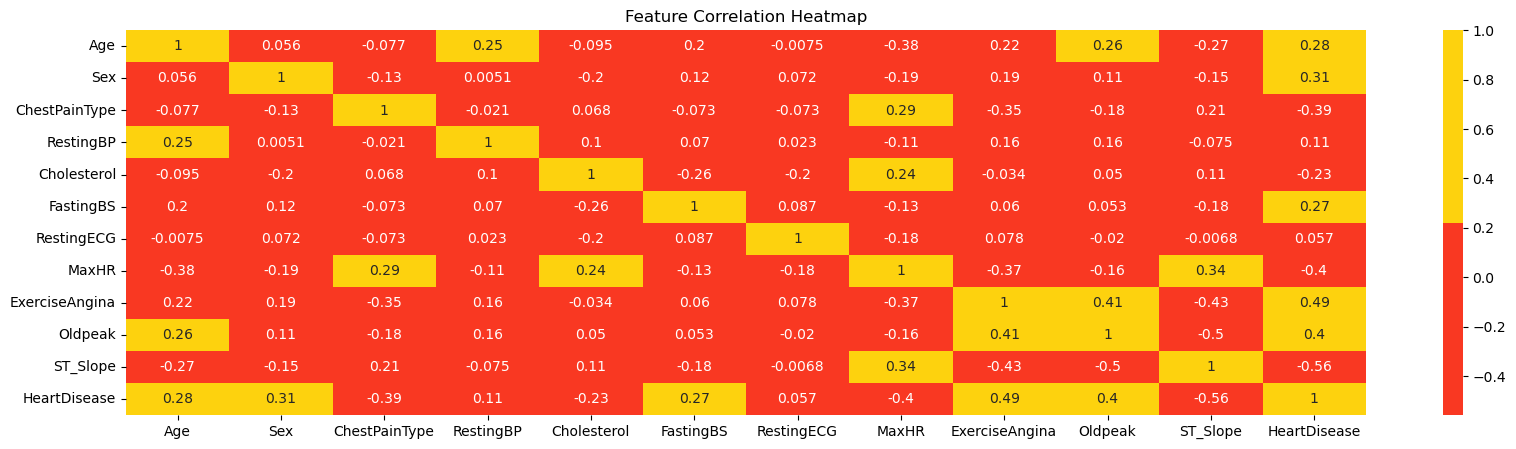

In [4]:
colors=['#F93822', '#FDD20E']# red and yellow

# Plot heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(hearts.corr(), cmap=colors, annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

As we can see, this a huge matrix with too many features. We will check the correlation only with respect to HeartDisease.

Text(0.5, 1.0, 'Correlation w.r.t HeartDisease')

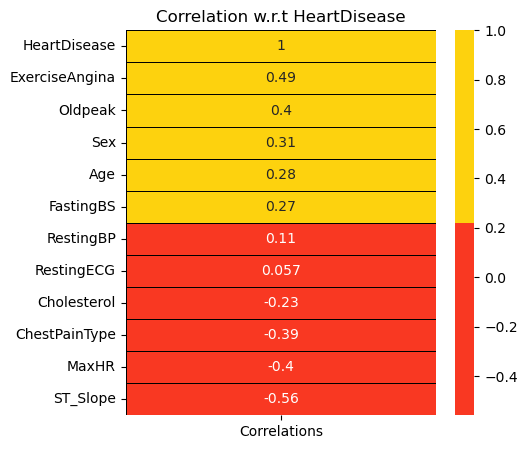

In [5]:
corr = hearts.corrwith(hearts['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease')

As we can see, except for RestingBP and RestingECG, everyone displays a positive or negative relationship with HeartDisease.

However, for the sake of simplicity and ease of use for the **Perceptron** algorithm we are implementing, I will be trying to predict the occurrence of heart disease in **Males that Excercise regularly**

In [43]:
# Select the features
# Filter dataset to include only:
# - Males (Sex == '1')
# - Yes to ExerciseAngina('ExerciseAngina' == '1')
filtered_df = hearts[
    (hearts["Sex"] == 1) &
    (hearts["ExerciseAngina"] == 1) 
]

# Select features most correlated with HeartDisease
selected_columns = [
    "Age", "Oldpeak", "MaxHR", "ST_Slope", "ExerciseAngina", "Sex", "HeartDisease","ChestPainType","Cholesterol","FastingBS"
]
filtered_df = filtered_df[selected_columns].reset_index(drop=True)

X = filtered_df[filtered_df.columns.drop(['HeartDisease'])].values
y = filtered_df['HeartDisease'].values
# y=np.where(y==0,-1,1)


## Split Dataset into Training and Testing Sets
This cell splits the dataset into training and testing subsets using an 80/20 split.

In [38]:
#Split data into test and trainung data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Perceptron and Evaluate Accuracy
This cell trains the Perceptron model using the training data and evaluates its performance on the test data.

In [39]:
# Train and predict
perceptron = Perceptron(epochs=1000)
perceptron.train(X_train, y_train)
y_pred = perceptron.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.85%


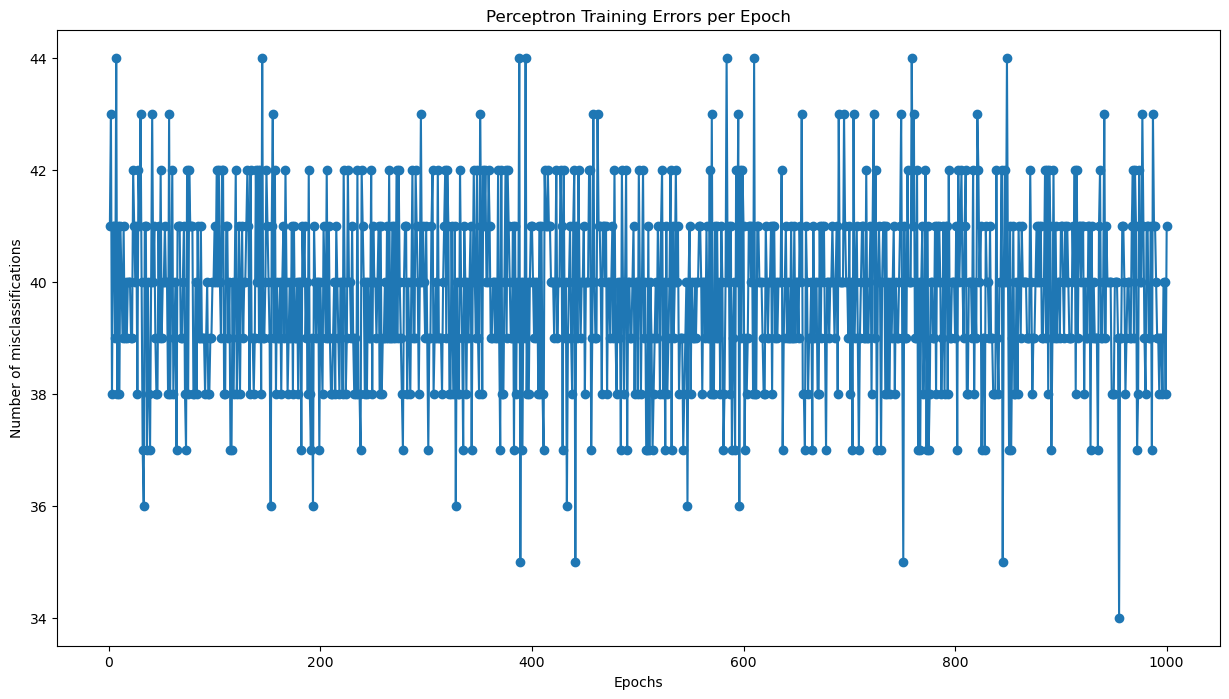

In [48]:
# Plot training errors
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(perceptron.errors_) + 1), perceptron.errors_, marker='o')
plt.title('Perceptron Training Errors per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

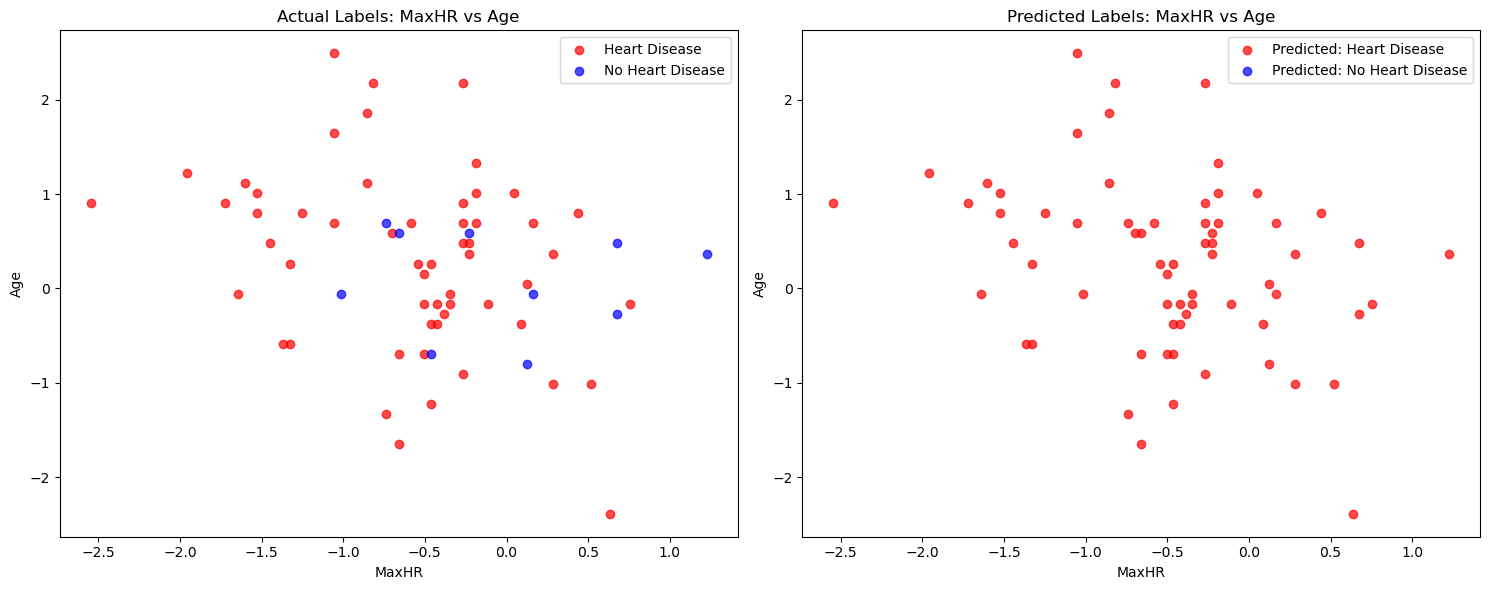

In [54]:
feature_names=["Age", "Oldpeak", "MaxHR", "ST_Slope", "ExerciseAngina", "Sex","ChestPainType","Cholesterol","FastingBS"]
# Prepare MaxHR and Age for plotting
if hasattr(X_test, 'columns'):
    X_plot = X_test[['MaxHR', 'Age']].values
else:
    maxhr_index = feature_names.index('MaxHR')
    age_index = feature_names.index('Age')
    X_plot = X_test[:, [maxhr_index, age_index]]

# Plot
plt.figure(figsize=(15, 6))

# Actual labels
plt.subplot(1, 2, 1)
plt.scatter(X_plot[y_test == 1, 0], X_plot[y_test == 1, 1], color='red', label='Heart Disease', alpha=0.7)
plt.scatter(X_plot[y_test == 0, 0], X_plot[y_test == 0, 1], color='blue', label='No Heart Disease', alpha=0.7)
plt.xlabel('MaxHR')
plt.ylabel('Age')
plt.title('Actual Labels: MaxHR vs Age')
plt.legend()

# Predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_plot[y_pred == 1, 0], X_plot[y_pred == 1, 1], color='red', label='Predicted: Heart Disease', alpha=0.7)
plt.scatter(X_plot[y_pred == 0, 0], X_plot[y_pred == 0, 1], color='blue', label='Predicted: No Heart Disease', alpha=0.7)
plt.xlabel('MaxHR')
plt.ylabel('Age')
plt.title('Predicted Labels: MaxHR vs Age')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we explored a Perceptron-based classification model to predict the presence of heart disease using key patient features.  
We focused particularly on visualizing the decision boundary of the model over two important features: **MaxHR (Maximum Heart Rate)** and **Age**.

The side-by-side scatter plots of actual vs. predicted labels — reveal the strengths and limitations of the Perceptron model:
- The model is able to capture some patterns in the data, especially for clearly separable cases.
- However, due to the linear nature of the Perceptron, it struggles with more complex, overlapping data distributions.

Further improvement may be possible with non-linear models, feature engineering, or kernel methods.
